<a href="https://colab.research.google.com/github/r-isachenko/2024-DGM-Summer-course/blob/main/seminars/seminar3/seminar3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Deep Generative Models</center>
## <center>Seminar 3</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>02.07.2024</center>


## Plan

- Flows Recap
- Planar and Radial Flows
- Forward vs Reverse KL

What do you remember about Normalizing flows?

<center><img src="pics/recap_flows.png" width=1200 /></center>

<left><img src="pics/flows_how2.png" width=1000 /></left>

We need:
1. Invertable mapping
2. Same dim 
3. Fast $\det J$ calculation

## Planar Flow


$g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^d, b \in \mathbb{R}\}$

$\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}} =  \mathbf{I} + \mathbf{u}h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T$

$\det \left|\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}}\right| =
\left(1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{I}^{-1}\mathbf{u} \right) \det(\mathbf{I}) =
1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T \mathbf{u}$

Let $h(x) = \tanh(x)$. When $g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$ is reversible?



$\mathbf{w}^T\mathbf{u} \geq -1$

## Planar Flow

$g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^d, b \in \mathbb{R}\}$

$\mathbf{w}^T\mathbf{u} \geq -1$

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as LA

w = np.array([5., 0])
u = np.array([1., 0])
b = 0

def h(x):
    return np.tanh(x)

def g(z, w=w, u=u, b=b):
    w = np.array(w)
    u = np.array(u)
    
    assert np.dot(w, u) >= -1
    y = z + np.dot(h(np.dot(z, w) + b).reshape(-1,1), u.reshape(1,-1))
    return y

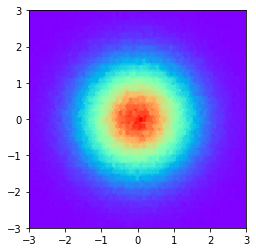

In [2]:
z = np.random.normal(size=(int(1e6),2))
plt.hexbin(z[:,0], z[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

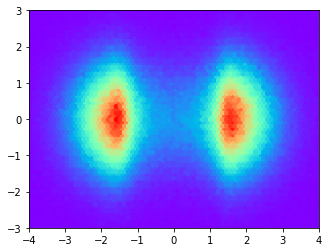

In [3]:
x = g(z)

plt.hexbin(x[:,0], x[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-4, 4])
plt.ylim([-3, 3])
plt.show()

## Radial Flow

$g(\mathbf{z}, \theta) = \mathbf{z} + \beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)$

$\theta = \{\alpha \in \mathbb{R}^{+}, \beta \in \mathbb{R}, \mathbf{z}_0 \in \mathbb{R}^{d} \}$

$r = ||\mathbf{z} - \mathbf{z}_0||$

$h(\alpha, r) = \dfrac{1}{\alpha + r}$

$g(\mathbf{z}, \theta) = \mathbf{z} + \beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)$

$\dfrac{\partial g(\mathbf{z})}{\partial \mathbf{z}} =
\mathbf{I} + \beta\left((\mathbf{z}-\mathbf{z}_0)h'(\alpha,r)\frac{\partial r}{\partial \mathbf{z}} + h(\alpha,r)\mathbf{I}\right)
=(1+\beta h(\alpha,r))\mathbf{I} + \beta h'(\alpha,r)(\mathbf{z}-\mathbf{z}_0)\frac{(\mathbf{z}-\mathbf{z}_0)^T}{||\mathbf{z}-\mathbf{z}_0||}$

$\det\dfrac{\partial f(\mathbf{z})}{\partial \mathbf{z}} =
\left(1 + \beta h'(\alpha,r)\frac{(\mathbf{z}-\mathbf{z}_0)^T}{||\mathbf{z}-\mathbf{z}_0||}\frac{\mathbf{I}}{\gamma}(\mathbf{z}-\mathbf{z}_0)\right)\det(\gamma\mathbf{I})
\
=\left(\frac{1 + \beta h(\alpha,r) + \beta h'(\alpha,r)||\mathbf{z}-\mathbf{z}_0||}{(1+\beta h(\alpha,r))}\right)(1+\beta h(\alpha,r))^d
=\left(1 + \beta h(\alpha,r) + \beta h'(\alpha,r)r\right)(1+\beta h(\alpha,r))^{d-1}$

$g(z)$ is reversible when $\beta \geq -\alpha$

## Radial Flow

$g(\mathbf{z}, \theta) = \mathbf{z} + \beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)$

$\theta = \{\alpha \in \mathbb{R}^{+}, \beta \in \mathbb{R}, \mathbf{z}_0 \in \mathbb{R}^{d} \}$

$r = ||\mathbf{z} - \mathbf{z}_0||$

$h(\alpha, r) = \dfrac{1}{\alpha + r}$

$\beta \geq -\alpha$

In [7]:
z0 = np.array([1, 0])
a = 2
b = 5

def h(r,a):
    return 1/(a+r)

def g(z, z0=z0, a=a, b=b):
    assert b >= -a
    z0 = np.array(z0)
    r = LA.norm(z - z0, axis=1).reshape(-1, 1)
    y = z + b * h(r,a) * (z - z0)
    return y

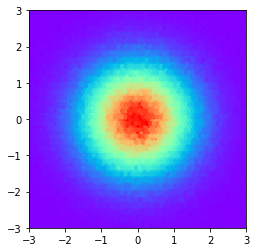

In [8]:
z = np.random.normal(size=(int(1e6),2))
plt.hexbin(z[:,0], z[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

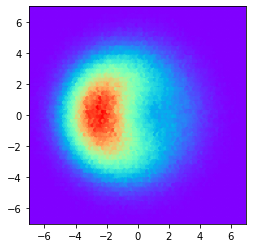

In [9]:
x = g(z)
plt.hexbin(x[:,0], x[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.show()

### Forward vs Reverse KL

### Recap

| what you know about $\pi(x)$  | problem you want to solve  | KL-divergence you use  | flow you model  | Objective  |
|---|---|---|---|---|
| Samples $X_1, \dots X_N$  | pdf estimation $\pi(x)$  | $$\text{Forward }KL(\pi(x) || p_{x}(x | \theta))\, , \,X \text{-space}$$  | $f_{\theta}: X \rightarrow Z$  | $$-E_{\pi(x)} \left(\log p_z(f(x, \theta)) +\\+ \log | \det J_f|\right)$$ |
| (unnormalized) pdf $\hat{\pi}(x)$  | sample from $\pi(x)$  |  $$\text{Reverse }KL(p_{x}(x | \theta) || \pi(x))\, , \,X \text{-space}$$ | $g_{\theta}: Z \rightarrow X$  | $$- E_{p(z)} \left( \log | \det J_g | +\\+ \log \pi(g(z, \theta))\right)$$  |
| Samples $X_1, \dots X_N$  |  pdf estimation $\pi(x)$ | $$\text{Reverse } KL(p_z(z|\theta) || p(z))\, , \,Z \text{-space}$$  | $f_{\theta} : X \rightarrow Z$  | $$- E_{\pi(x)} \left( \log | \det J_f | +\\+ \log p_z(f(x, \theta))\right)$$  |
| (unnormalized) pdf $\hat{\pi}(x)$ | sample from $\pi(x)$  | $$\text{Forward }KL(p(z) || p_{z}(z|\theta))\, , \,Z \text{-space}$$  | $$g_{\theta} : Z \rightarrow X$$   |  $$-E_{p_z(z)} \left(\log \pi(g(z, \theta)) +\\+ \log | \det J_g|\right)$$ |


### KL duality theorem

$$\arg\min\limits_{\theta} KL(\pi(x) || p(x|\theta)) = \arg\min\limits_{\theta} KL(p(z|\theta) || p(z))$$

$$\arg\min\limits_{\theta} KL(p(x || \theta), \pi(x)) = \arg\min\limits_{\theta} KL(p(z) || p(z|\theta))$$

### Forward KL:
- $f(x) = z$
- PDF estimation
- MLE
- Requires to calculate: $f, \det J_f, p_z(z)$
- Requires to sample from $\pi(x)$

---

### Reverse KL:
- $g(z) = x$
- Sampling from $\pi(x)$
- Not MLE
- Requires to calculate: $g, \det J_g$, need to eval $\pi(x)$
- Requires to sample from $p_z(z)$